In [34]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from copy import deepcopy
from tqdm import tqdm

# define the data, 2-D sphere

In [35]:
sample_size = 10000
data_dim = 2
train_data = torch.randn(sample_size,data_dim)
train_data /= torch.norm(train_data,dim=1).reshape(-1,1)

# visualization (if data_dim=2)

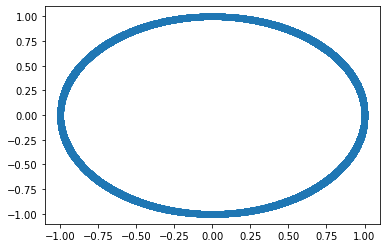

In [36]:
plt.scatter(train_data[:,0],train_data[:,1])

# define the time-dependent MLP

In [43]:
class Net(nn.Module):
    
    def __init__(self, input_dim, output_dim, conditon_dim):
        super(Net, self).__init__()
        # First fully connected layer
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.condition_dim = conditon_dim
        self.fc1 = nn.Linear(input_dim + conditon_dim, 10000)
        # Second fully connected layer that outputs our 10 labels
        self.fc2 = nn.Linear(10000, 10000)
        self.fc3 = nn.Linear(10000, output_dim)

        # classifier output
        self.fc1_c = nn.Linear(input_dim, 2048)
        self.fc2_c = nn.Linear(2048, 2048)
        self.fc3_c = nn.Linear(2048, 1) # classifier output

        
    def forward(self, x, t):
        inp = torch.cat((x, t), dim=1)
        out = self.fc1(inp)
        out = torch.relu(out)
        out = self.fc2(out)
        out = torch.relu(out)
        out = self.fc3(out)

        # classifier output
        out_c = self.fc1_c(x)
        out_c = torch.relu(out_c)
        out_c = self.fc2_c(out_c)
        out_c = torch.relu(out_c)
        out_c = self.fc3_c(out_c)
        out_c = torch.sigmoid(out_c)

        return out, out_c

# define the denoising loss

In [48]:
def denoising_prediction_loss(net, batch_data, eps = 1e-5):
    batch_len = len(batch_data)
    noisy_levels = (torch.rand(batch_len).view(-1,1).cuda()) * (1 - eps) # 0 ~ 1-eps
    noise = torch.randn(batch_data.shape).cuda()
    noisy_data = batch_data * torch.sqrt(1 - noisy_levels) + torch.sqrt(noisy_levels) * noise
    predicted_noise, predicted_noise_level = net(noisy_data, noisy_levels)
    denoise_loss  = torch.mean(torch.sum((predicted_noise - noise)**2, dim = 1)) 
    level_loss = torch.mean((predicted_noise_level - noisy_levels)**2)
    loss = denoise_loss + level_loss
    return loss

# training

In [49]:
def index_iterator(data_len, batch_size, shuffle=True):
    if shuffle:
        indices = np.random.permutation(data_len)
    else:
        indices = np.arange(data_len)
    for i in range(0, data_len, batch_size):
        yield indices[i:i+batch_size]

In [53]:
EPOCH = 100

lr=5e-4
batch_size = 32

model = Net(data_dim, data_dim, 1).cuda()
EMA_model = Net(data_dim, data_dim, 1).cuda()
EMA_model.load_state_dict(deepcopy(model.state_dict()))
train_data = train_data.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

progress = tqdm(range(EPOCH))
for epoch in progress:
    avg_loss = 0
    totals = 0
    for batch_idx in index_iterator(len(train_data), batch_size):
        optimizer.zero_grad()
        loss  = denoising_prediction_loss(model, train_data[batch_idx])
        loss.backward()
        optimizer.step()
        totals += len(batch_idx)
        avg_loss += loss.item() * len(batch_idx)
    
    for p, ema_p in zip(model.parameters(), EMA_model.parameters()):
        ema_p.data.mul_(0.99).add_(0.01, p.data)

    progress.set_postfix({"avg_loss":avg_loss/totals,"last_loss":loss.item()})


100%|██████████| 100/100 [09:05<00:00,  5.46s/it, avg_loss=0.726, last_loss=0.57]


# generation with ddim

In [54]:
def ddim_sampling(model, sample_size = 100, total_steps = 1000, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = 1 - eps
    interp = now_coeff / total_steps
    #sample_points = np.sqrt(1-now_coeff) * train_data[:100,:] + np.sqrt(now_coeff) * torch.randn(100,2).cuda()
    sample_points = torch.randn(sample_size,2).cuda()

    for _ in range(total_steps-1):
        #nl = eta * np.sqrt((now_coeff - interp)/now_coeff) * np.sqrt(1-(1-now_coeff)/(1-now_coeff+interp))
        nl = eta * np.sqrt(now_coeff - interp) 
        with torch.no_grad():
            direction, _ = model(sample_points, torch.zeros(sample_size,1).cuda() + now_coeff)
        sample_points = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction + nl * torch.randn(sample_size,2).cuda()
        now_coeff -= interp

    return sample_points.cpu().numpy()

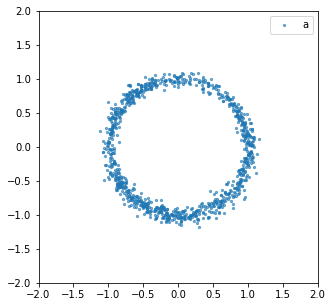

In [56]:
sample_points = ddim_sampling(model, 1000, eta = 0.5)
plt.figure(figsize=(5,5))
plt.scatter(sample_points[:,0], sample_points[:,1], s=5, alpha=0.6, label="a")
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.legend()
plt.show()

# diffusion from stationary point perspective

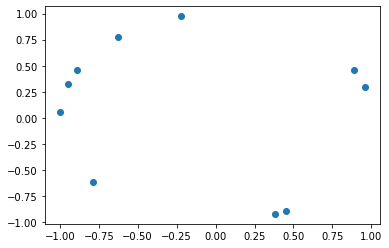

In [58]:
source_points = np.random.randn(10, 2)
source_points /= np.linalg.norm(source_points, axis=1)[:, None]

plt.scatter(source_points[:, 0], source_points[:, 1])
plt.show()

# with given noise scale

In [67]:
# source point iteration
def source_point_iteration(x,source_points,noise_scale):
    scaled_source_points = source_points * np.sqrt(1 - noise_scale)
    x_norm = np.linalg.norm(x,axis=1).reshape(-1,1) ** 2
    source_points_norm = np.linalg.norm(scaled_source_points,axis=1).reshape(1,-1) ** 2
    x_distance_to_source_points = x_norm - 2 * np.matmul(x,scaled_source_points.T) + source_points_norm
    weights = np.exp(-x_distance_to_source_points / (2 * noise_scale))
    weights = weights / np.sum(weights,axis=1).reshape(-1,1)
    x_new = np.matmul(weights,source_points)
    return x_new

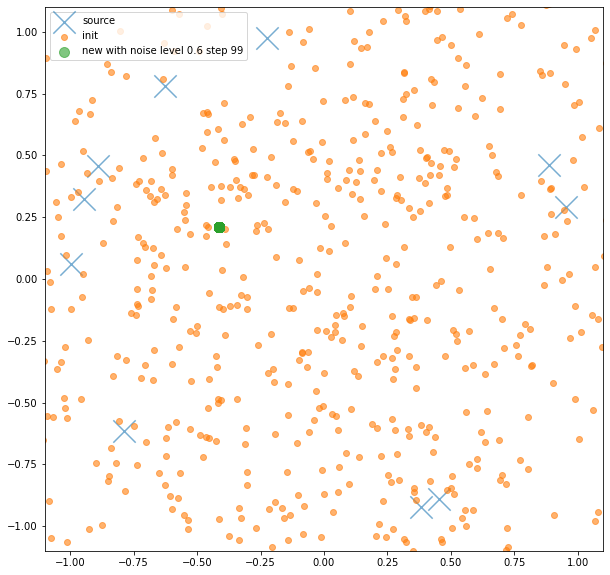

In [78]:
num_samples = 1000
noise_level = 0.6
total_steps = 100
x_init_points = np.random.randn(num_samples, 2)
plt.figure(figsize=(10,10))
plt.scatter(source_points[:,0],source_points[:,1],s=500,marker="x",alpha=0.6,label='source')
plt.scatter(x_init_points[:,0],x_init_points[:,1],alpha=0.6,label='init')
for step in range(total_steps):
    x_init_points = source_point_iteration(x_init_points, source_points, noise_level)
plt.scatter(x_init_points[:,0],x_init_points[:,1],s=100,alpha=0.6,label='new with noise level %.1f step %d' % (noise_level, step))
plt.legend()
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.show()

# source point iteration with estimated noise scale

In [88]:
# source point iteration
def source_point_iteration_with_estimate_noise(x, source_points, estimate_interval = 1000, eps = 1e-5):
    # noise estimation
    x_norm = np.linalg.norm(x,axis=1).reshape(-1,1) ** 2
    x_source_product = np.matmul(x,source_points.T)
    source_points_norm = np.linalg.norm(source_points,axis=1).reshape(1,-1) ** 2
    use_mu = np.linspace(eps,1-eps, estimate_interval)
    weighted_mu = np.zeros((len(x),1))
    total_weights = np.zeros((len(x),1))
    for mu in use_mu:
        temp_distance = x_norm - 2 * np.sqrt(1 - mu) * x_source_product + source_points_norm * (1 - mu)
        temp_weights = np.exp(-temp_distance / (2 * mu)).sum(axis=1).reshape(-1,1)
        weighted_mu += temp_weights * mu
        total_weights += temp_weights
    noise_scale = weighted_mu / total_weights
    print('noise scale: ', noise_scale.mean())
    
    x_distance_to_source_points = x_norm - 2 * np.sqrt(1 - noise_scale) * x_source_product + source_points_norm * (1 - noise_scale)
    weights = np.exp(-x_distance_to_source_points / (2 * noise_scale))
    weights = weights / np.sum(weights,axis=1).reshape(-1,1)
    x_new = np.matmul(weights,source_points)
    return x_new

noise scale:  0.6752172355285886
noise scale:  0.6534925105853872
noise scale:  0.6554894791090201
noise scale:  0.6517799329555991
noise scale:  0.6488898348859176
noise scale:  0.6471634857666669
noise scale:  0.6461989773961175
noise scale:  0.6456731858777072
noise scale:  0.6453896506870183
noise scale:  0.6452375549354327
noise scale:  0.6451561840842118
noise scale:  0.6451127111614755
noise scale:  0.6450895023840016
noise scale:  0.6450771167544386
noise scale:  0.6450705083766418
noise scale:  0.645066982848022
noise scale:  0.6450651021096967
noise scale:  0.6450640988368819
noise scale:  0.645063563653601
noise scale:  0.645063278169318
noise scale:  0.645063125883371
noise scale:  0.6450630446496466
noise scale:  0.6450630013172889
noise scale:  0.6450629782026046
noise scale:  0.645062965872594
noise scale:  0.6450629592954275
noise scale:  0.6450629557869865
noise scale:  0.645062953915488
noise scale:  0.6450629529171791
noise scale:  0.645062952384654
noise scale:  0.6

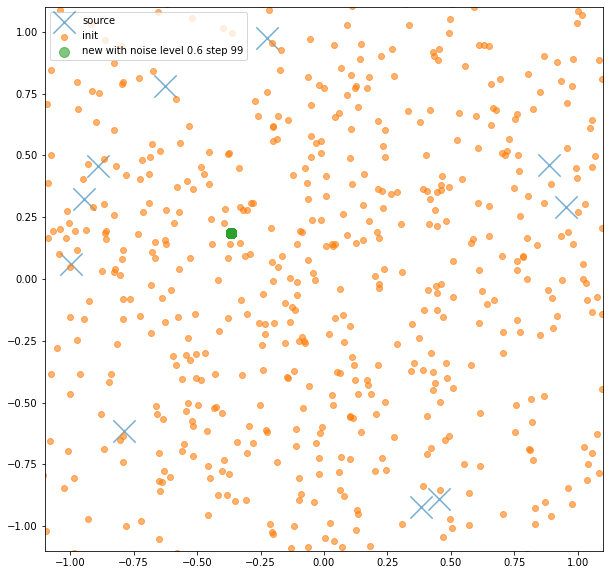

In [90]:
num_samples = 1000
total_steps = 100
x_init_points = np.random.randn(num_samples, 2)
plt.figure(figsize=(10,10))
plt.scatter(source_points[:,0],source_points[:,1],s=500,marker="x",alpha=0.6,label='source')
plt.scatter(x_init_points[:,0],x_init_points[:,1],alpha=0.6,label='init')
for step in range(total_steps):
    x_init_points = source_point_iteration_with_estimate_noise(x_init_points, source_points)
plt.scatter(x_init_points[:,0],x_init_points[:,1],s=100,alpha=0.6,label='new with noise level %.1f step %d' % (noise_level, step))
plt.legend()
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.show()